CFE Data Assimilation of USGS streamflow data. Real Data Example

In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

In [2]:
## Open BMI's for each file
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [3]:
## Initialize the BMI's
# Fake forcing data
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_modell.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json') # I am confused what this config file should look like


# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')


# 2016 and 2017 Case Study 
# cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')

# enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config_16_17.json')


initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


              time  APCP_surface  RAINRATE      T2D       Q2D     U2D     V2D  \
0     5/15/17 0:00           0.0       0.0  284.078  0.006616  6.0804 -1.9670   
1     5/15/17 1:00           0.0       0.0  283.180  0.006650  6.0304 -2.0740   
2     5/15/17 2:00           0.0       0.0  282.440  0.006614  5.9856 -2.1828   
3     5/15/17 3:00           0.0       0.0  281.662  0.006476  5.9402 -2.2888   
4     5/15/17 4:00           0.0       0.0  281.702  0.006530  6.3688 -2.5458   
..             ...           ...       ...      ...       ...     ...     ...   
763  6/15/17 19:00           0.0       0.0  295.270  0.007334 -1.1600  4.5018   
764  6/15/17 20:00           0.0       0.0  294.610  0.006788 -1.2230  4.4990   
765  6/15/17 21:00           0.0       0.0  293.624  0.006776 -1.2812  4.4996   
766  6/15/17 22:00           0.0       0.0  292.722  0.006714 -1.5682  3.8524   
767  6/15/17 23:00           0.0       0.0  291.554  0.006650 -1.8486  3.1996   

          PSFC   SWDOWN   L

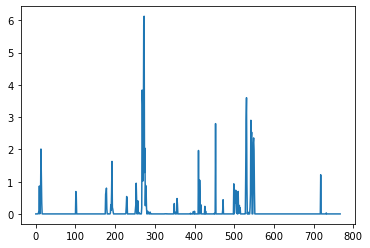

In [4]:
## Look at forcing data if interested
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

Final Framework for running each CFE model, EnKF DA, and USGS. 

In [5]:
#Make empty matrices for plotting
cfeOpen     = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF     = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): 
    
    # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip +1) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip +1)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip +1)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) # Need array for EnKf function. Should get this when initialize CFS 
    
    # Check validity when there is missing data
    validity = usgs.get_value('validity')[i]
    print("-------------------------------------------------")
    print("validity",validity)

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variable originial values from CFE Peturbed to update in EnKF
    soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
    surface_runoff                 = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    
    # Set outflow for CFE Open and CFE Peturbed to plot
    outflow        = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
   
    # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
    outflow_peturb       = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    outflow_peturb_mean  = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting

    # Set EnKF state variable values to state variables from CFE Petubred
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) 
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
    enkf.set_value('surface_runoff_depth_m', surface_runoff)
    enkf.set_value('storage_max_m',storage_max_m)
    
    # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf_validity=enkf.set_value('validity',validity) #check validity if needed
    enkf.update()

    # For plotting if needed
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get updated state variable values from EnKF to pass into CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

    # Set CFE analysis state variable changes from EnKF to get final true streamflow values
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) 
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) 
    # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting CFE Analysis from newly updated state variables. FINAL MODEL! 
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 
        
    # Get CFE Analysis state variables to then pass back into CFE Peturbed 
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

    # Set updated state variables into CFE Peturbed for the loop of updating state variables to continue! 
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
# Finalize the models! 
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()


-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.33997484961299995
EnKF Code predicted, X Post [166.6769017]
***********under estimaiton ratio [23.07379348]
Observation BMI [166.5]
CFE [7.22364538]
enkf [166.6769017]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.13763417700537006
EnKF Code predicted, X Post [161.07583801]
surface_runoff_ratio [109.97365077]
Leftover vol 0.0
surface _runoff [109.97365077]
***********over estimaiton ratio [1.]
Observation BMI [161.]
CFE [229.64509201]
enkf [161.07583801]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.05327258587887107
EnKF Code predicted, X Post [156.69250734]
surface_runoff_ratio [107.23115136]
Leftover vol 0.0
surface _runoff [107.23115136]
****

Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [81.87113982]
***********under estimaiton ratio [1.71796536]
Observation BMI [81.9]
CFE [47.65587357]
enkf [81.87113982]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [80.68898004]
***********under estimaiton ratio [1.65518641]
Observation BMI [81.]
CFE [48.74917974]
enkf [80.68898004]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [80.40759794]
***********under estimaiton ratio [2.48959085]
Observation BMI [80.425]
CFE [32.29751508]
enkf [80.40759794]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_s

validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019449535719104
EnKF Code predicted, X Post [58.62574533]
***********under estimaiton ratio [2.04495486]
Observation BMI [58.7]
CFE [28.66847894]
enkf [58.62574533]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019642565045293
EnKF Code predicted, X Post [58.01256413]
***********under estimaiton ratio [2.44222565]
Observation BMI [58.]
CFE [23.75397382]
enkf [58.01256413]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019683536883882
EnKF Code predicted, X Post [58.293048]
surface_runoff_ratio [30.71087376]
Leftover vol 0.0
surface _runoff [30.71087376]
***********over estimaiton ratio [1.]
Observation BMI [58.]
CFE [61.21449681]
enkf [58.293048]
-----------------------------------------

Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [41.04281195]
***********under estimaiton ratio [1.3858277]
Observation BMI [40.7]
CFE [29.6161002]
enkf [41.04281195]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [40.96030868]
***********under estimaiton ratio [1.87062467]
Observation BMI [40.7]
CFE [21.89659389]
enkf [40.96030868]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [39.93982231]
***********under estimaiton ratio [1.03614711]
Observation BMI [39.875]
CFE [38.5464786]
enkf [39.93982231]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_sto

Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019692359835473
EnKF Code predicted, X Post [45.02882212]
***********under estimaiton ratio [1.94390948]
Observation BMI [45.2]
CFE [23.16405295]
enkf [45.02882212]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019462281335444
EnKF Code predicted, X Post [45.1267972]
***********under estimaiton ratio [1.2517562]
Observation BMI [45.2]
CFE [36.05078792]
enkf [45.1267972]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02101964527039124
EnKF Code predicted, X Post [44.68511302]
***********under estimaiton ratio [2.13320754]
Observation BMI [44.6]
CFE [20.94738193]
enkf [44.68511302]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storag

EnKF Code predicted, X Post [51.98965833]
***********under estimaiton ratio [1.26519003]
Observation BMI [51.95]
CFE [41.09237124]
enkf [51.98965833]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019652961947743
EnKF Code predicted, X Post [58.00079644]
***********under estimaiton ratio [1.507184]
Observation BMI [57.7]
CFE [38.48289032]
enkf [58.00079644]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019685743701166
EnKF Code predicted, X Post [64.87780744]
***********under estimaiton ratio [1.57496489]
Observation BMI [65.175]
CFE [41.19317703]
enkf [64.87780744]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02097642331003735
EnKF Code predicted, X Post [77.10964873]
surface_runoff_r

EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [91.19829694]
***********under estimaiton ratio [2.57778341]
Observation BMI [90.8]
CFE [35.37857243]
enkf [91.19829694]
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [88.21646456]
***********under estimaiton ratio [2.26910638]
Observation BMI [88.7]
CFE [38.87718324]
enkf [88.21646456]
-------------------------------------------------
validity 0.0
Beginning---------------

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:69: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


 [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [79.93332269]
***********under estimaiton ratio [2.52944685]
Observation BMI [80.1]
CFE [31.60110786]
enkf [79.93332269]
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [78.13132524]
***********under estimaiton ratio [2.31676115]
Observation BMI [78.3]
CFE [33.72437642]
enkf [78.13132524]
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0


-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694250070442
EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694507403375
EnKF Code predicted, X Post [57.0250391]
***********under estimaiton ratio [1.89600236]
Observation BMI [57.]
CFE [30.07646004]
enkf [57.0250391]
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694562024238
EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694573617742
EnKF Code predicted, X Post [56.59463491]
***********under estimaiton rati

EnKF Code predicted, X Post [57.42067309]
***********under estimaiton ratio [1.68848912]
Observation BMI [57.65]
CFE [34.00713232]
enkf [57.42067309]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021018558169092483
EnKF Code predicted, X Post [56.47890321]
***********under estimaiton ratio [1.39138002]
Observation BMI [56.6]
CFE [40.59200404]
enkf [56.47890321]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019453366762364
EnKF Code predicted, X Post [56.04859645]
***********under estimaiton ratio [1.46045318]
Observation BMI [55.95]
CFE [38.37753731]
enkf [56.04859645]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02101964337821083
EnKF Code predicted, X Post [54.77298495]
***********unde

EnKF Code predicted, X Post [43.32904292]
***********under estimaiton ratio [1.05716852]
Observation BMI [42.9]
CFE [40.98593737]
enkf [43.32904292]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019692851184768
EnKF Code predicted, X Post [41.41464806]
***********under estimaiton ratio [1.15961595]
Observation BMI [41.8]
CFE [35.71410693]
enkf [41.41464806]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694210479778
EnKF Code predicted, X Post [41.80012537]
***********under estimaiton ratio [1.16069238]
Observation BMI [41.8]
CFE [36.01309532]
enkf [41.80012537]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694498999986
EnKF Code predicted, X Post [41.53648605]
***********under

EnKF Code predicted, X Post [100.72321323]
***********under estimaiton ratio [1.64499302]
Observation BMI [100.925]
CFE [61.23017664]
enkf [100.72321323]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02098035982613311
EnKF Code predicted, X Post [108.3152219]
***********under estimaiton ratio [2.30451044]
Observation BMI [108.25]
CFE [47.00140205]
enkf [108.3152219]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02099472349197229
EnKF Code predicted, X Post [112.8150219]
***********under estimaiton ratio [2.33614128]
Observation BMI [113.]
CFE [48.29118116]
enkf [112.8150219]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021014394658871005
EnKF Code predicted, X Post [115.94070179]
**********

EnKF Code predicted, X Post [85.58804396]
***********under estimaiton ratio [2.36823481]
Observation BMI [85.5]
CFE [36.14001605]
enkf [85.58804396]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [84.25535664]
***********under estimaiton ratio [2.01688418]
Observation BMI [84.6]
CFE [41.77501]
enkf [84.25535664]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [83.78339198]
***********under estimaiton ratio [1.66662252]
Observation BMI [83.7]
CFE [50.27136663]
enkf [83.78339198]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [83.20655576]
***********under es

self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [47.80146951]
***********under estimaiton ratio [1.24716429]
Observation BMI [47.5]
CFE [38.32812562]
enkf [47.80146951]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [46.65314642]
***********under estimaiton ratio [1.26309976]
Observation BMI [46.3]
CFE [36.93544083]
enkf [46.65314642]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [45.91519373]
***********under estimaiton ratio [1.29589974]
Observation BMI [46.3]
CFE [35.43113111]
enkf [45.91519373]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.0210196945767

EnKF Code predicted, X Post [33.86286263]
***********under estimaiton ratio [1.11978573]
Observation BMI [33.85]
CFE [30.24048411]
enkf [33.86286263]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [33.69854084]
***********under estimaiton ratio [1.46309365]
Observation BMI [33.6]
CFE [23.03238807]
enkf [33.69854084]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [33.5065472]
surface_runoff_ratio [19.52064999]
Leftover vol 0.0
surface _runoff [19.52064999]
***********over estimaiton ratio [1.]
Observation BMI [33.6]
CFE [35.08613798]
enkf [33.5065472]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02101

self.f 100.0
soil_storage_deficit_from CFE 0.0210196945767277
EnKF Code predicted, X Post [24.72791586]
surface_runoff_ratio [16.84555538]
Leftover vol 0.0
surface _runoff [16.84555538]
***********over estimaiton ratio [1.]
Observation BMI [24.5]
CFE [30.37777072]
enkf [24.72791586]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02101969457673858
EnKF Code predicted, X Post [24.31127867]
***********under estimaiton ratio [1.02829758]
Observation BMI [24.5]
CFE [23.64225987]
enkf [24.31127867]
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02101969457674102
EnKF Code predicted, X Post [24.77756873]
***********under estimaiton ratio [1.27415108]
Observation BMI [24.5]
CFE [19.44633494]
enkf [24.77756873]
-------------------------------------------------
validity 1.0
Beginning------------------

Plot the data to see the results of CFE Analysis! 

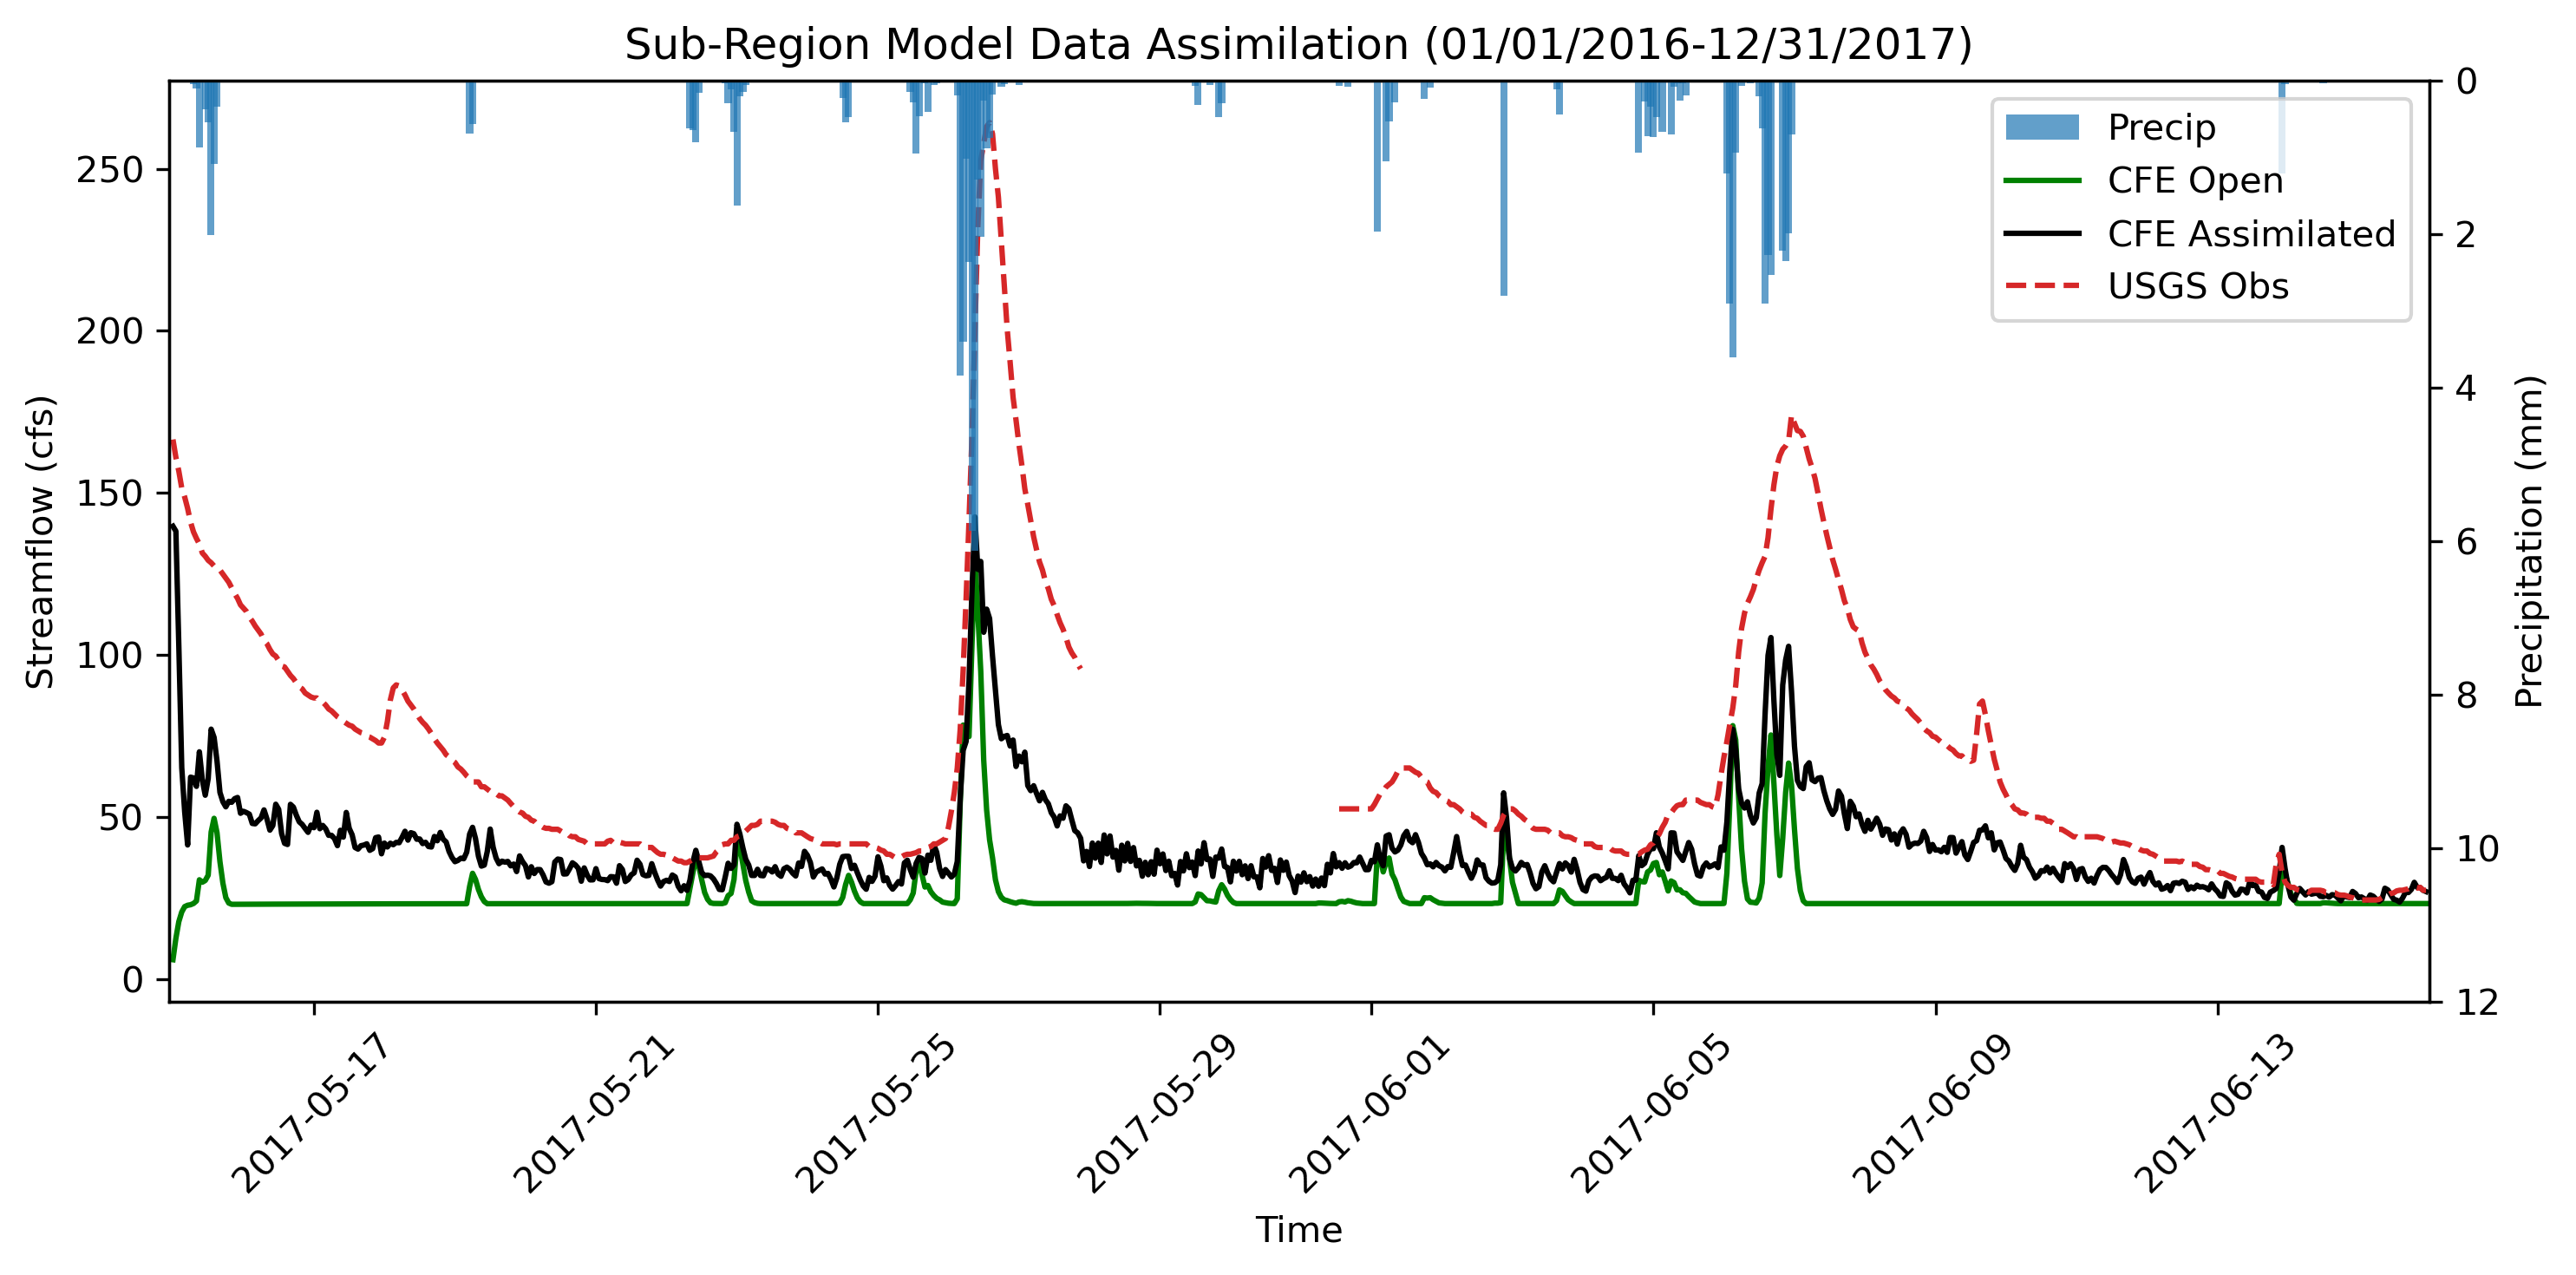

In [17]:
# Define time range for plotting
istart_plot=0
iend_plot=720
x = list(range(istart_plot, iend_plot))

# Get Date out of forcing file for plotting on x-axis
Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

# Make double y-axis to plot precipitation on top of of the plot. Set labels and limits for axes
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()

ax1.set_xlabel('Time')
ax1.tick_params(axis='x', labelrotation = 45)
#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
ax1.set_ylabel('Streamflow (cfs)')

plt.title('Sub-Region Model Data Assimilation (01/01/2016-12/31/2017)')
#plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')

# Plot the variables on the plot! 
Precip = ax2.bar(df_forcing['time'], df_forcing['APCP_surface'],width=0.1,alpha=0.7, color="tab:blue", label = 'Precip')
Open, = ax1.plot(df_forcing['time'], cfeOpen, color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(df_forcing['time'], cfeAnalysis, color = 'black', label = 'CFE Assimilated')
Obs, = ax1.plot(df_forcing['time'], obs, color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

# Plot the legend and fix layout
plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("SubRegionModel.png")
plt.show()


Get statistics to see the improvement of CFE Analysis

In [20]:
# Put values into dataframe to calculate statistics
df = pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True) #drop NaN values
df.reset_index(drop=True, inplace=True) #reset index

# CFE Open Evaluation
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("CFE Open Statistics")
print("r_open     =",r_open[0])
print("KGE_open   =",kge_open[0])
print("NSE_open   =", nse_open[0])
print("PBIAS_open =", pbias_open[0])
print("--------------------------")

# CFE Analysis Evaluation
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("CFE Analysis Statistics")
print("r_analysis     =",r_analysis[0])
print("KGE_analysis   =",kge_analysis[0])
print("NSE_analysis   =", nse_analysis[0])
print("PBIAS_analysis =", pbias_analysis[0])
print("--------------------------")

# Mean and Std of Models and Observations
print("Mean and STD of Models and Observations")
print("mean_obs      =",np.mean(df["obs"]))
print("STD_obs       =",np.std(df["obs"]))
print("mean_open     =",np.mean(df["cfeOpen"]))
print("STD_open      =",np.std(df["cfeOpen"]))
print("mean_analysis =",np.mean(df["cfeAnalysis"]))
print("STD_analysis  =",np.std(df["cfeAnalysis"]))

CFE Open Statistics
r_open     = 0.3942471460267489
KGE_open   = -2.593655846185467
NSE_open   = -31.95498758094964
PBIAS_open = -157.16828669631977
--------------------------
CFE Analysis Statistics
r_analysis     = 0.8875769308116103
KGE_analysis   = -0.696635840105245
NSE_analysis   = -4.8060906314735234
PBIAS_analysis = -64.82556987164385
--------------------------
Mean and STD of Models and Observations
mean_obs      = 66.93546270718221
STD_obs       = 40.45261101684418
mean_open     = 26.027883751554423
STD_open      = 9.690485992488075
mean_analysis = 40.60987792082728
STD_analysis  = 15.777930862461456
